### **Setting up the data for training**

In [ ]:
#Referred resources:
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
#https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5


# Loading the libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
from zipfile import ZipFile
import numpy as np

#mounting to the drive
from google.colab import drive
drive.mount('/content/gdrive')

#extrcating all the data from zip file
data="/content/gdrive/MyDrive/qure.ai/cxr_plaksha_assignment_qure.zip"
with ZipFile(data,"r") as zip:
  zip.extractall("/content/plaksha_cxr/images")

#path of images stores
data_path="/content/plaksha_cxr/images/cxr_plaksha_assignment_qure"



Mounted at /content/gdrive


In [ ]:
#loading the csv data
gt_data=pd.read_csv("/content/gdrive/MyDrive/qure.ai/consolidation_train_gt.csv")
gt_data

,filename,consolidation,consolidation-left,consolidation-right
0,19047,0,0,0
1,17924,0,0,0
2,11658,0,0,0
3,10733,0,0,0
4,15041,0,0,0
...,...,...,...,...
15995,2807,1,1,0
15996,16442,0,0,0
15997,8959,0,0,0
15998,18714,0,0,0


In [ ]:
gt_data.drop_duplicates(['filename'],inplace=True)

In [ ]:
i = '8335.png'
(gt_data[gt_data['filename']==int(i[:-4])]['consolidation']).values

array([1])

In [ ]:
# Data preparation
curr_path = '/content'
os.mkdir(curr_path+'/data')
os.mkdir(curr_path+'/data/train')
os.mkdir(curr_path+'/data/train/clean')
os.mkdir(curr_path+'/data/train/consolidation')
cnt = 0
for i in os.listdir('/content/plaksha_cxr/images/cxr_plaksha_assignment_qure'):
    cnt += 1
    img_path = '/content/plaksha_cxr/images/cxr_plaksha_assignment_qure/'+str(i)
    #print(gt_data[gt_data['filename']==int(i[:-4])]['consolidation'])
    if (gt_data[gt_data['filename']==int(i[:-4])]['consolidation']).values:
        shutil.move(img_path,'data/train/consolidation')
    else:
        shutil.move(img_path,'data/train/clean')
    if cnt%1000 == 0:
        print(str(cnt)+ ' images moved')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # This is added back by InteractiveShellApp.init_path()


1000 images moved
2000 images moved
3000 images moved
4000 images moved
5000 images moved
6000 images moved
7000 images moved
8000 images moved
9000 images moved
10000 images moved
11000 images moved
12000 images moved
13000 images moved
14000 images moved
15000 images moved
16000 images moved
17000 images moved
18000 images moved
19000 images moved
20000 images moved


In [ ]:
# Creating validation data
data_dir = '/content/data/train'
dest = '/content/data/val'
test_size = 2000
os.mkdir(dest)
for class_ in os.listdir(data_dir):
    os.mkdir(dest+ '/'+class_)
    dir = os.listdir(data_dir + '/'+class_)
    test_class = dir[:test_size]
    for file in test_class:
        #print(file)
        shutil.move((data_dir + '/'+class_+'/'+file), dest+'/'+class_)

In [ ]:
## Creating test data

data_dir = '/content/data/train'
dest = '/content/data/test'
test_size = 1000
os.mkdir(dest)
for class_ in os.listdir(data_dir):
    os.mkdir(dest+ '/'+class_)
    dir = os.listdir(data_dir + '/'+class_)
    test_class = dir[:test_size]
    for file in test_class:
        #print(file)
        shutil.move((data_dir + '/'+class_+'/'+file), dest+'/'+class_)

### **Model building**

In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([transforms.Resize((128, 128)),
        transforms.ToTensor(),
      
    ]),
    'val': transforms.Compose([transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]),
}

data_dir = '/content/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

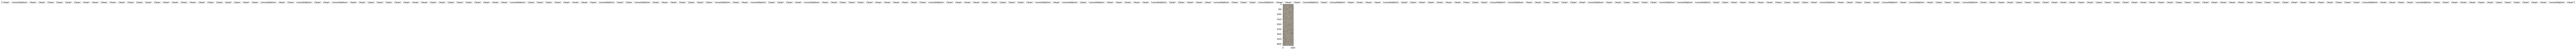

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### **Training the model using transfer learning**

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3723 Acc: 0.8914
val Loss: 1.1237 Acc: 0.5010

Epoch 1/4
----------
train Loss: 0.2698 Acc: 0.9105
val Loss: 1.0853 Acc: 0.5030

Epoch 2/4
----------
train Loss: 0.2490 Acc: 0.9106
val Loss: 1.1316 Acc: 0.5032

Epoch 3/4
----------
train Loss: 0.2320 Acc: 0.9112
val Loss: 1.1673 Acc: 0.5055

Epoch 4/4
----------
train Loss: 0.2145 Acc: 0.9126
val Loss: 1.2291 Acc: 0.5050

Training complete in 30m 27s
Best val Acc: 0.505500


**The accuracy of the validation data is increasing with more epochs but due to time limitations, I have only checked till 5 epochs**

### **Checking performance on test data**

In [ ]:
data_dir = '/content/data/test'
test_transforms = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.ToTensor(),
                                     ])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    #input = Variable(image_tensor)
    input = image_tensor.to(device)
    output = model_ft(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels


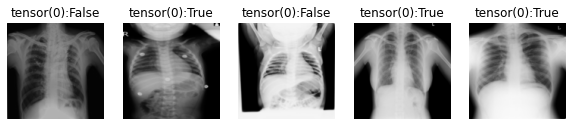

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()